In [1]:
# frontend config
from IPython.core.display import display, HTML
#change width of pane
display(HTML("<style>.container { width:98% !important; }</style>"))
%config Completer.use_jedi = False
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from numpy import pi, r_
from scipy import optimize

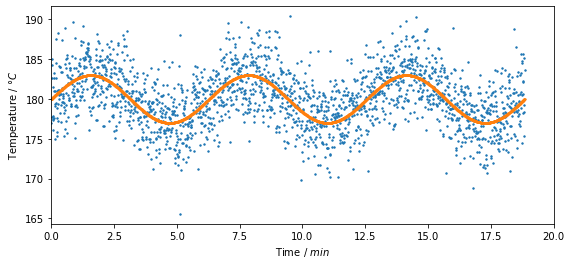

In [2]:
fig,ax = plt.subplots(1,1,figsize=(9,4))

N = 2000 # number of data points
xcenter = 180
t = np.linspace(0, 6*np.pi, N)
y = xcenter + np.sin(t)*3 + np.random.randn(N)*3 

y_real = xcenter + np.sin(t)*3

ax.scatter(t,y,s=2)
ax.scatter(t,y_real,s=2)
ax.set_xlim(0,20)
u = ax.set_xlabel("Time / $min$")
u = ax.set_ylabel("Temperature / $°C$")

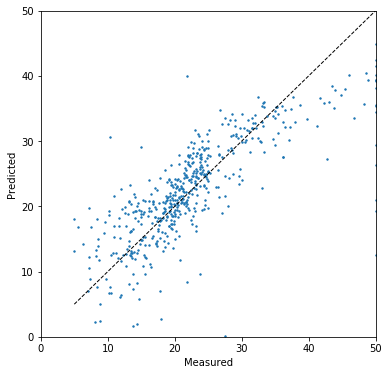

In [3]:
lr = linear_model.LinearRegression()
boston = datasets.load_boston()
y = boston.target

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, boston.data, y, cv=10)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(y, predicted,s=2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xlim(0,50)
ax.set_ylim(0,50)
plt.show()

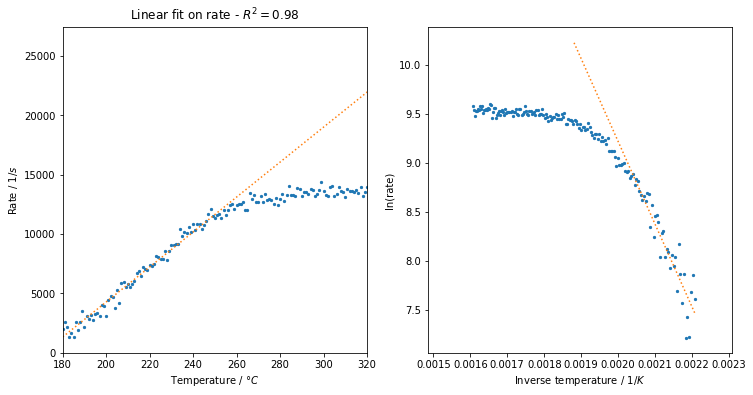

In [4]:
N=20

# temp in K
T_min = 180
T_max = 350

x = np.arange(T_min,T_max,1)

crossover = 220
smoothing = 40

kinetic_regime = crossover - T_min 
apparently_kinetic = crossover + smoothing - T_min 

switch = 0.5+0.5*np.tanh((x-crossover)/smoothing)

def arrhenius(k_0,E_A,T):
    return k_0 * np.exp(- E_A / (8.314 * (T+273.15)))

# rate, with some... noise
y_kinetic = arrhenius(1e12,80000,x)
y_diffusion = arrhenius(3e4,4000,x)
                            
y = switch * y_diffusion + (1-switch) * y_kinetic + np.random.randn(len(x))*4e2 

x = x.reshape((-1, 1))

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,6))

model = LinearRegression()
model = LinearRegression().fit(x[:apparently_kinetic], y[:apparently_kinetic])
y_pred = model.predict(x)

ax1.scatter(x,y,s=5,label="mixed")
ax1.plot(x,y_pred,color="C1",linestyle=":")

ax1.set_xlabel('Temperature / $°C$')
ax1.set_ylabel('Rate / $1/s$')
ax1.set_ylim(0,)
ax1.set_xlim(T_min,320)

ax1.set_title(f"Linear fit on rate - $R^2=${r2_score(y[:apparently_kinetic],y_pred[:apparently_kinetic]):.2}")

#####

one_over_T = 1/(x+273.15)
ln_r = np.log(y)

ax2.scatter(one_over_T,ln_r,s=5)

model = LinearRegression()
#model.fit(one_over_T[:t_max-crossover], ln_r[:t_max-crossover])
model = LinearRegression().fit(one_over_T[:kinetic_regime], ln_r[:kinetic_regime])
ln_r_pred = model.predict(one_over_T[:kinetic_regime+smoothing])
ax2.plot(one_over_T[:kinetic_regime+smoothing],ln_r_pred,color="C1",linestyle=":")

ax2.set_xlim(1/(400+273.15),1/(160+273.15))
ax2.set_xlabel('Inverse temperature / $1/K$')
ax2.set_ylabel('ln(rate)')

plt.show()

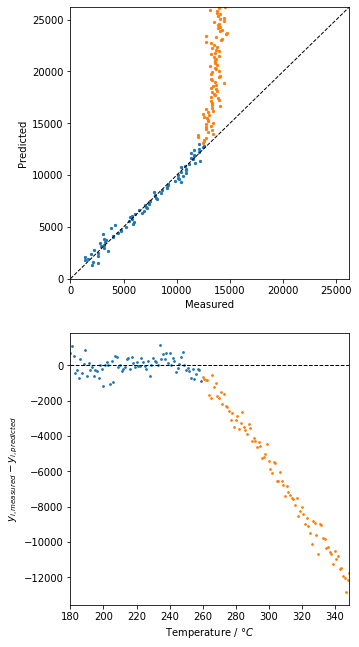

In [5]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(5,11))

ax1.plot([0, y_pred.max()], [0, y_pred.max()], 'k--', lw=1)
ax1.set_xlim(0,y_pred.max())
ax1.set_ylim(0,y_pred.max())
ax1.set_xlabel('Measured')
ax1.set_ylabel('Predicted')
ax1.scatter(y[:apparently_kinetic],y_pred[:apparently_kinetic],s=5)
ax1.scatter(y[apparently_kinetic:],y_pred[apparently_kinetic:],s=5)


ax2.set_ylabel('$y_{i,measured} - y_{i,predicted}$')
ax2.set_xlabel("Temperature / $°C$")
ax2.plot([x.min(),x.max()], [0,0], 'k--', lw=1)
ax2.set_xlim(x.min(),x.max())

ax2.scatter(x[:apparently_kinetic],y[:apparently_kinetic]-y_pred[:apparently_kinetic],s=3)
ax2.scatter(x[apparently_kinetic:],y[apparently_kinetic:]-y_pred[apparently_kinetic:],s=3)


Text(0, 0.5, 'count')

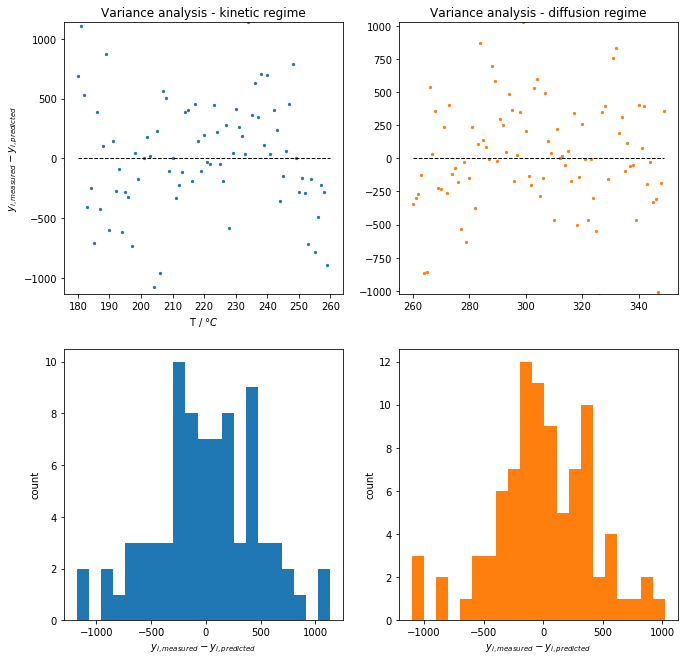

In [6]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(11,11))

ax1.plot([x.min(),crossover + smoothing], [0,0], 'k--', lw=1)
 #ax.set_xlim(0,x.max())
ax1.set_xlabel('T / $°C$')
ax1.set_ylabel('$y_{i,measured} - y_{i,predicted}$')


model = LinearRegression()
model = LinearRegression().fit(x[:apparently_kinetic], y[:apparently_kinetic])
y_pred = model.predict(x[:apparently_kinetic])

ax1.set_title(f"Variance analysis - kinetic regime")    
delta = y[:apparently_kinetic]-y_pred
ax1.scatter(x[:apparently_kinetic],delta,s=5,color="C0")
ax1.set_ylim(-delta.max(),delta.max())
    
ax3.hist(delta,color="C0",bins=21)
ax3.set_xlabel("$y_{i,measured} - y_{i,predicted}$")
ax3.set_ylabel("count")

ax2.plot([crossover + smoothing,x.max()], [0,0], 'k--', lw=1)

model = LinearRegression()
model = LinearRegression().fit(x[apparently_kinetic:], y[apparently_kinetic:])
y_pred = model.predict(x[apparently_kinetic:])

ax2.set_title(f"Variance analysis - diffusion regime")    
delta = y[apparently_kinetic:]-y_pred
ax2.scatter(x[apparently_kinetic:],delta,s=5,color="C1")
ax2.set_ylim(-delta.max(),delta.max())
    
ax4.hist(delta,color="C1",bins=21)
ax4.set_xlabel("$y_{i,measured} - y_{i,predicted}$")
ax4.set_ylabel("count")

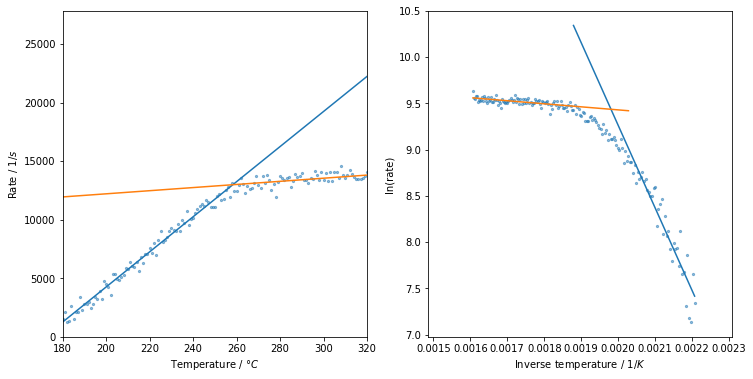

In [7]:
N=20

# temp in K
T_min = 180
T_max = 350

x = np.arange(T_min,T_max,1)

crossover = 220
smoothing = 40

kinetic_regime = crossover - T_min 
apparently_kinetic = crossover + smoothing - T_min 

switch = 0.5+0.5*np.tanh((x-crossover)/smoothing)

def arrhenius(k_0,E_A,T):
    return k_0 * np.exp(- E_A / (8.314 * (T+273.15)))

# rate, with some... noise
y_kinetic = arrhenius(1e12,80000,x)
y_diffusion = arrhenius(3e4,4000,x)
                            
y = switch * y_diffusion + (1-switch) * y_kinetic + np.random.randn(len(x))*4e2 

x = x.reshape((-1, 1))

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,6))

model = LinearRegression()
model = LinearRegression().fit(x[:apparently_kinetic], y[:apparently_kinetic])
y_pred = model.predict(x)

ax1.scatter(x,y,s=5,label="mixed",alpha=0.5)
ax1.plot(x,y_pred,color="C0")

model = LinearRegression()
model = LinearRegression().fit(x[apparently_kinetic:], y[apparently_kinetic:])
y_pred = model.predict(x)
ax1.plot(x,y_pred,color="C1")

ax1.set_xlabel('Temperature / $°C$')
ax1.set_ylabel('Rate / $1/s$')
ax1.set_ylim(0,)
ax1.set_xlim(T_min,320)



#####

one_over_T = 1/(x+273.15)
ln_r = np.log(y)

ax2.scatter(one_over_T,ln_r,s=5,alpha=0.5)

model = LinearRegression()
model = LinearRegression().fit(one_over_T[:kinetic_regime], ln_r[:kinetic_regime])
ln_r_pred = model.predict(one_over_T[:kinetic_regime+smoothing])
ax2.plot(one_over_T[:kinetic_regime+smoothing],ln_r_pred,color="C0")

model = LinearRegression()
model = LinearRegression().fit(one_over_T[kinetic_regime+smoothing:], ln_r[kinetic_regime+smoothing:])
ln_r_pred = model.predict(one_over_T[kinetic_regime:])
ax2.plot(one_over_T[kinetic_regime:],ln_r_pred,color="C1")

ax2.set_xlim(1/(400+273.15),1/(160+273.15))
ax2.set_xlabel('Inverse temperature / $1/K$')
ax2.set_ylabel('ln(rate)')

plt.show()

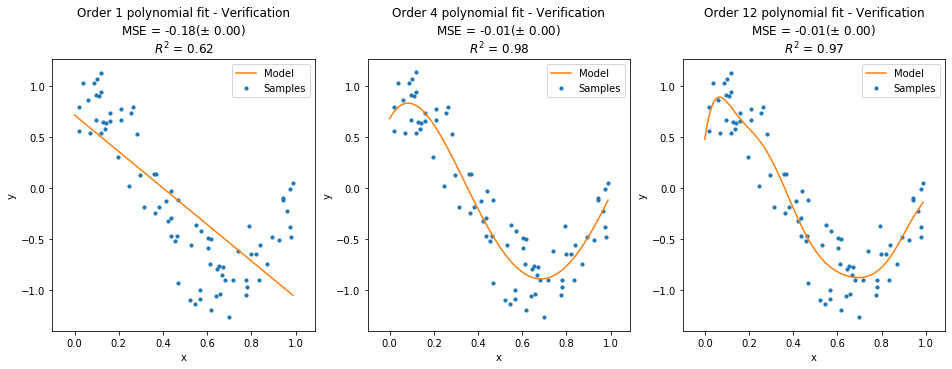

In [8]:
# Fit the first set

#return np.cos(1.5 * np.pi * X)
fitfunc = lambda p, x: p[0]*np.cos(np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function

def true_fun(X):
    return np.cos(1.5 * np.pi * X)
    #return 0.6*(X-5)**2 + 15

np.random.seed(0)

N = 80
xmax = 1
degrees = [1, 4, 12]

X = np.sort(np.random.rand(N))
y = true_fun(X) + np.random.randn(len(X)) *0.25 

X_test = np.linspace(0, X.max(), 100)

plt.figure(figsize=(16, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    #plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    #score_MSE = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)
    #score_R2 = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="r2", cv=10)

    Y_pred = pipeline.predict(X_test[:, np.newaxis])
    Y_true = true_fun(X_test)
    
    score_r2 = r2_score(Y_true,Y_pred)
    score_MSE = mean_squared_error(Y_true,Y_pred)
    
  
    plt.plot(X_test, Y_pred, label="Model",color="C1")
    #plt.plot(X_test, Y_true, label="True function",color="C0")
    plt.scatter(X, y, s=10, label="Samples")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0-0.1, X.max()+0.1))
    #plt.ylim(0,y.max())
    plt.legend(loc="best")
    plt.title(f"Order {degrees[i]} polynomial fit - Verification\nMSE = {-score_MSE.mean():.2f}($\pm$ {score_MSE.std():.2f})\n$R^2$ = {score_r2:.2f}")

#ax = plt.subplot(1, len(degrees)+1, len(degrees)+1)

p0 = [.7, 0.5, .1, -1] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(X, y))

time = np.linspace(X.min(), X.max(), 100)
#plt.plot(X, y, "o",color="C0",markersize=3, label="Samples")
#plt.plot(time, fitfunc(p1, time), "r",color="C1", label="Model")
#plt.legend(loc="best")
#plt.title(f"Cosine fit - Verification\nMSE = {-score_MSE.mean():.2e}(+/- {score_MSE.std():.2e})\n$R^2$ = {score_r2:.2f}")
    
plt.show()

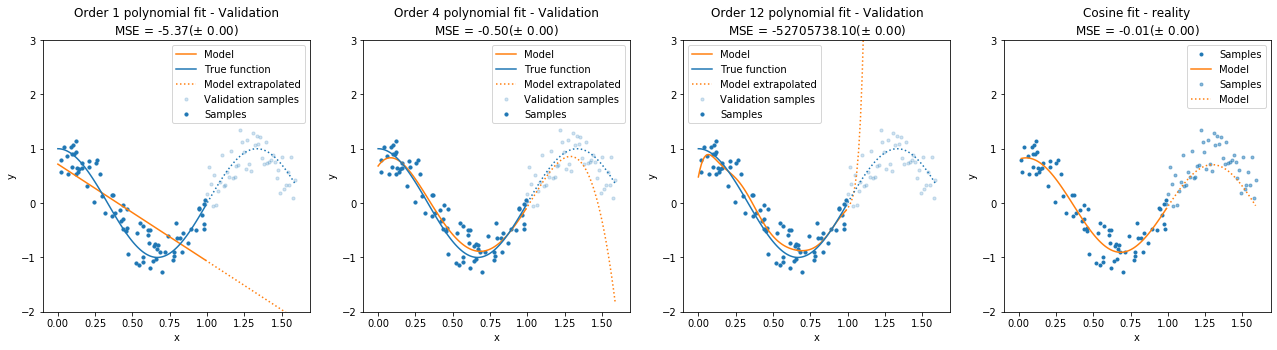

In [9]:
X_extra = np.linspace(X.max(), X.max()+0.6, 50)
y_extra = true_fun(X_extra) + np.random.randn(len(X_extra)) *0.25 #*boost - boost/3

plt.figure(figsize=(22, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees)+1, i + 1)
    #plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])

    pipeline.fit(X[:, np.newaxis], y)

    Y_pred = pipeline.predict(X_test[:, np.newaxis])
    Y_true = true_fun(X_test) 

    Y_pred_e = pipeline.predict(X_extra[:, np.newaxis])
    Y_true_e = true_fun(X_extra)
    
    score_r2_e = r2_score(Y_true_e,Y_pred_e)
    
    score_MSE_e = mean_squared_error(Y_true_e,Y_pred_e)
    
    plt.plot(X_test, Y_pred, label="Model",color="C1")
    plt.plot(X_test, Y_true, label="True function",color="C0")
    plt.scatter(X_extra, y_extra, s=10,color="C0", label="Validation samples",alpha=0.2)
    plt.scatter(X, y, s=10,color="C0", label="Samples")
    plt.plot(X_extra, Y_pred_e, label="Model extrapolated",color="C1",linestyle=":")
    plt.plot(X_extra, Y_true_e, label="",color="C0",linestyle=":")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0-0.1, X_extra.max()+0.1))
    plt.ylim(-2,3)
    plt.legend(loc="best")
    plt.title(f"Order {degrees[i]} polynomial fit - Validation\nMSE = {-score_MSE_e.mean():.2f}($\pm$ {score_MSE_e.std():.2f})")

    
ax = plt.subplot(1, len(degrees)+1, len(degrees)+1)

plt.plot(X, y, "o",color="C0",markersize=3, label="Samples")
plt.plot(time, fitfunc(p1, time), "r",color="C1", label="Model")

score_r2 = r2_score(Y_true_e,fitfunc(p1, X_extra))

plt.title(f"Cosine fit - reality\nMSE = {-score_MSE.mean():.2f}($\pm$ {score_MSE.std():.2f})")

plt.plot(X_extra, y_extra, "o",color="C0",alpha=0.5,markersize=3, label="Samples")
plt.plot(X_extra, fitfunc(p1, X_extra), ":",color="C1", label="Model")    

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0-0.1, X_extra.max()+0.1))
plt.ylim(-2,3)
plt.legend(loc="best")


plt.show()

In [10]:
# Fit the first set

#return np.cos(1.5 * np.pi * X)
fitfunc = lambda p, x: p[0]*np.cos(np.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [.7, 0.5, .1, -1] # Initial guess for the parameters
p1, success = optimize.leastsq(errfunc, p0[:], args=(X, y))

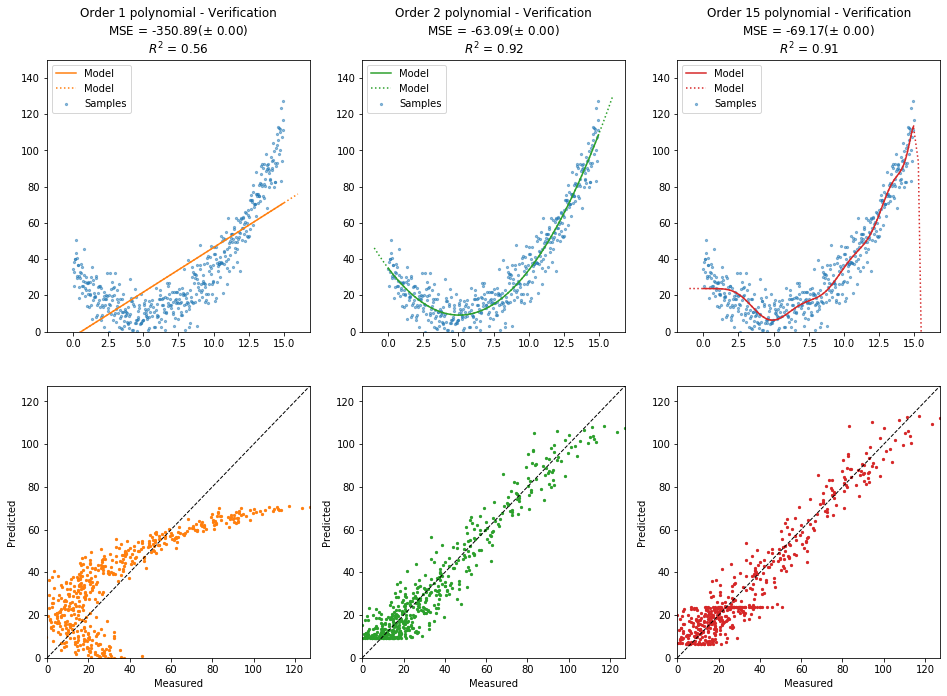

In [11]:
N=15

degrees = [1,2,15]

x = np.arange(0,N,0.03)
y = (x-5)**2 +10+ np.random.randn(len(x))*8

Y_true = (x-5)**2 +10

x = x.reshape((-1, 1))

fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(16,11))

flatten = lambda t: [item for sublist in t for item in sublist]

for ax in [ax1,ax2,ax3]:
    ax.scatter(x,y,s=5,label="Samples",alpha=0.5)
    #ax.set_xlim(0,N)
    ax.set_ylim(0,150)
    
for ax in [ax4,ax5,ax6]: 
    ax.plot([0, y.max()], [0, y.max()], 'k--', lw=1)
    ax.set_xlim(0,y.max())
    ax.set_ylim(0,y.max())
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
axes = fig.get_axes()
    
for i,degree in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(x, y)
    Y_pred = pipeline.predict(x)
    
    X_test = np.linspace(-1, N+1, 50).reshape((-1, 1))
    Y_extra = pipeline.predict(X_test)
    
    #score_MSE = cross_val_score(pipeline, x, y, scoring="neg_mean_squared_error", cv=20)
    score_MSE = mean_squared_error(y, Y_pred)
    score_r2 = r2_score(y, Y_pred)
    
    axes[i].set_title(f"Order {degree:} polynomial - Verification\nMSE = {-score_MSE.mean():.2f}($\pm$ {score_MSE.std():.2f})\n$R^2$ = {score_r2:.2f}")
    axes[i].plot(x,Y_pred,color=f"C{i+1:}",label="Model")
    axes[i].plot(X_test,Y_extra,color=f"C{i+1:}",linestyle=":",label="Model")
    axes[i].legend(loc="best")
    axes[i+3].scatter(y, Y_pred,s=5,color=f"C{i+1:}")
    

plt.show()

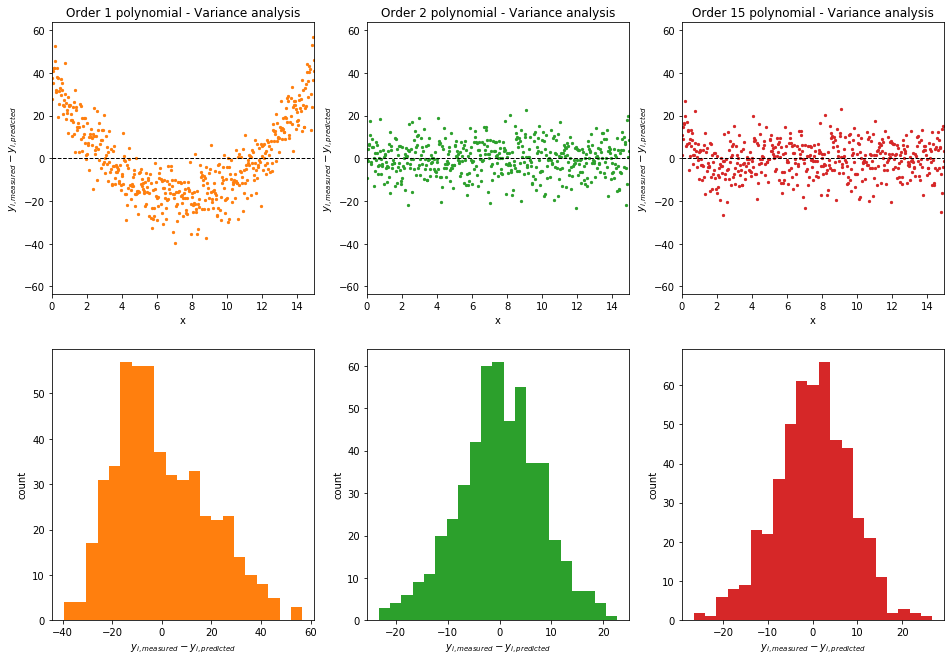

In [12]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(16,11))

axes = fig.get_axes()

for ax in [ax1,ax2,ax3]: 
    ax.plot([0,x.max()], [0,0], 'k--', lw=1)
    ax.set_xlim(0,x.max())
    ax.set_ylim(-y.max()/2.,y.max()/2.)
    ax.set_xlabel('x')
    ax.set_ylabel('$y_{i,measured} - y_{i,predicted}$')

for i,degree in enumerate(degrees):    
    
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(x, y)
    Y_pred = pipeline.predict(x)
    
    X_test = np.linspace(-1, N+1, 50).reshape((-1, 1))
    Y_extra = pipeline.predict(X_test)

    delta = y-Y_pred
    
    axes[i].scatter(x,delta,s=5,color=f"C{i+1:}")
    
    axes[i+3].hist(delta,color=f"C{i+1:}",bins=21)
    axes[i+3].set_xlabel("$y_{i,measured} - y_{i,predicted}$")
    axes[i+3].set_ylabel("count")
    
    axes[i].set_title(f"Order {degree:} polynomial - Variance analysis")

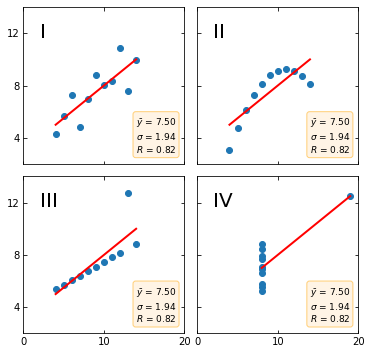

In [13]:
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6),
                        gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x, y, 'o')

    # linear regression
    p1, p0 = np.polyfit(x, y, deg=1)
    x_lin = np.array([np.min(x), np.max(x)])
    y_lin = p1 * x_lin + p0
    ax.plot(x_lin, y_lin, 'r-', lw=2)

    # add text box for the statistics
    stats = (f'$\\bar y$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$R$ = {np.corrcoef(x, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')

plt.show()